This notebook is to understand INN framework by applying it to different examples 

Importing modules

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mc
import colorsys
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet, ConditionNode
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom, RNVPCouplingBlock
from torch.cuda.amp import GradScaler, autocast
%run FABRIK_method_copy.ipynb

Color Intensity setting

In [3]:
def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

Setting up

In [4]:
# Cell 2: Parameters and Device Setup
parameters={'l':2.0}
num_inputs=4*3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
number_points=30
reps=10000
TEST_TRAIN_SPLIT=0.8
BATCH_SIZE=1000
num_samples = reps*number_points
current_lr=1e-3
num_epochs=15
mix_precision = False
mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
width_exponents=[0.05,0.2,0.9]

Defining MMD

In [5]:
# Cell 3: MMD Calculation
def MMD_matrix_multiscale(x, y, widths_exponents,device):
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    dxx = torch.clamp(rx.t() + rx - 2.*xx, 0, np.inf)
    dyy = torch.clamp(ry.t() + ry - 2.*yy, 0, np.inf)
    dxy = torch.clamp(rx.t() + ry - 2.*xy, 0, np.inf)
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    for C,a in widths_exponents:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a
    return torch.mean(XX + YY - 2.*XY)
for key, value in parameters.items():
    if isinstance(value, torch.Tensor):
        parameters[key] = value.to(device)

Defining the local INN architecture

In [6]:
# Cell 4: INN Model Definition
class loc_INN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device=device
        self.num_blocks=6
        self.inn=self.inn_model()
        self.trainable_params=[p for p in self.inn.parameters() if p.requires_grad]
        if not self.trainable_params:
            print("No trainable paramters found..--> Exiting")
            raise SystemExit
        for param in self.trainable_params:
            param.data = 0.05 * torch.randn_like(param)

    def inn_model(self):
        def subnet_fc(cin,cout):
            return nn.Sequential(nn.Linear(cin,24),nn.ReLU(),nn.Linear(24,cout))
        nodes=[InputNode(int(num_inputs),name='input')]
        for k in range(self.num_blocks):
            nodes.append(Node(nodes[-1],GLOWCouplingBlock,{'subnet_constructor': subnet_fc,'clamp':2.0},conditions=None,name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],PermuteRandom,{'seed':k},name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1],name='output'))
        return ReversibleGraphNet(nodes , verbose=False).to(self.device)

    def forward(self, x):
        return self.inn(x)
    
    def reverse(self, y_rev):
        return self.inn(y_rev, rev=True)

loc_inn=loc_INN(device)
loc_inn=loc_inn.to(torch.float32)
loc_inn=loc_inn.to(device)
MSE_loss=torch.nn.MSELoss().to(device) 
l1_loss=torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(loc_inn.trainable_params, lr=current_lr)
scaler=GradScaler(enabled=mix_precision)
scheduler=ExponentialLR(optimizer,gamma=0.95)


/tmp/ipykernel_16465/3480856377.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler(enabled=mix_precision)


Setting up position functions

In [7]:
num_link = 4

# Cell 5: Position and End Effector Functions
def positions(phi,l=parameters["l"]*np.ones((num_link,))):
    x, y=np.zeros((num_link+1,1)), np.zeros((num_link+1,1))
    for i in range(1, num_link+1):
        x[i,:], y[i,:]=x[i-1,:]+l[i-1]*np.cos(phi[i-1]), y[i-1,:]+l[i-1]*np.sin(phi[i-1])
    return np.concatenate((x,y),axis=1)

def posn(phi,l=parameters["l"]*np.ones((num_link,))):
    x, y=np.zeros((num_link+1,)), np.zeros((num_link+1,))
    for i in range(1, num_link+1):
        x[i], y[i]=x[i-1]+l[i-1]*np.cos(phi[i-1]), y[i-1]+l[i-1]*np.sin(phi[i-1])
    return x,y

def end_effector_posn(phi, l=parameters["l"]*np.ones((num_link,))):
    x, y = np.zeros((phi.shape[0], 1)), np.zeros((phi.shape[0], 1))
    for i in range(phi.shape[1]):
        x += l[i]*np.cos(phi[:,i]).reshape((phi.shape[0],1))
        y += l[i]*np.sin(phi[:,i]).reshape((phi.shape[0],1))
    return np.concatenate((x,y),axis=1)

Generating data, in a circular trajectory

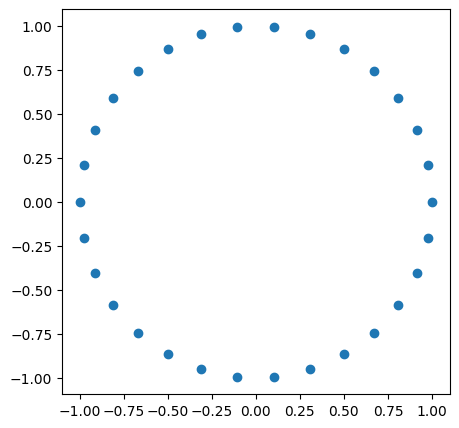

In [8]:
# Cell 6: Generate Circle Points
radius_taken = 1
centre_point= np.array([[0,0]])
angles_array = np.zeros((number_points,))
for i in range(0,angles_array.shape[0]):
    angles_array[i] =i*2*np.pi/number_points
x=np.zeros((angles_array.shape[0],1))
y=np.zeros((angles_array.shape[0],1))
for i in range(angles_array.shape[0]):
    x[i,:] = centre_point[0,0]+radius_taken*np.cos(angles_array[i])
    y[i,:] = centre_point[0,1]+radius_taken*np.sin(angles_array[i])
circle_points = np.concatenate((x,y),axis=1)
plt.figure(figsize=(5,5))
plt.scatter(circle_points[:,0],circle_points[:,1])
plt.show()

Data Generation

In [9]:
import numpy as np
import pandas as pd
import torch

np.random.seed(1)

ini_thetas = np.random.randn(reps, num_link)
ini_configs = np.zeros((reps, num_link + 1, 2))

for i in range(reps):
    ini_configs[i, :, :] = positions(ini_thetas[i, :])

values_inv = np.zeros((reps * number_points, num_link * 3 + 2))
generated_thetas = np.zeros((reps * number_points, 1, num_link))
generated_config = np.zeros((reps * number_points, num_link + 1, 2))
generated_vel = np.zeros((reps * (number_points - 1), num_link + 1, 2))
generated_acc = np.zeros((reps * (number_points - 2), num_link + 1, 2))
generated_theta_vel = np.zeros((reps * (number_points - 1), 1, num_link))
generated_theta_acc = np.zeros((reps * (number_points - 2), 1, num_link))

vel_index = 0
acc_index = 0

for i in range(number_points):
    temp_thetas, temp_config, temp_vel, temp_acc = FABRIK_solver(
        aim=np.reshape(circle_points[i, :], (1, 2)), p=ini_configs
    )
    
    num_valid = temp_thetas.shape[0]
    
    generated_thetas[i * reps : i * reps + num_valid, :, :] = temp_thetas
    generated_config[i * reps : i * reps + num_valid, :, :] = temp_config

    if i < number_points - 1:
        valid_reps = min(reps, temp_vel.shape[0])
        generated_vel[vel_index : vel_index + valid_reps, :, :] = temp_vel[:valid_reps, :, :]
        vel_index += valid_reps

        for j in range(i * reps, i * reps + valid_reps - 1):
            generated_theta_vel[j, :, :] = velocity(generated_thetas[j, :, :], generated_thetas[j + 1, :, :], j, j + 1)

    if i < number_points - 2:
        valid_reps = min(reps, temp_acc.shape[0])
        generated_acc[acc_index : acc_index + valid_reps, :, :] = temp_acc[:valid_reps, :, :]
        acc_index += valid_reps

        for j in range(i * reps, i * reps + valid_reps - 1):
            generated_theta_acc[j, :, :] = acceleration(generated_theta_vel[j, :, :], generated_theta_vel[j + 1, :, :], j, j + 1)

    for j in range(i * reps, i * reps + num_valid):
        target = np.reshape(circle_points[i, :], (1, 2))
        if j < i * reps + num_valid - 2 and i < number_points - 2:
            solution_set = np.concatenate((generated_thetas[j, :, :], generated_theta_vel[j, :, :], generated_theta_acc[j, :, :], target), axis=1)
        elif j < i * reps + num_valid - 1 and i < number_points - 1:
            solution_set = np.concatenate((generated_thetas[j, :, :], generated_theta_vel[j, :, :], np.zeros((1, num_link)), target), axis=1)
        else:
            solution_set = np.concatenate((generated_thetas[j, :, :], np.zeros((1, num_link)), np.zeros((1, num_link)), target), axis=1)
        
        values_inv[j, :] = solution_set

values_inv = np.unique(values_inv, axis=0)

p_x, p_y = np.zeros((values_inv.shape[0], num_link + 1)), np.zeros((values_inv.shape[0], num_link + 1))

for val in range(values_inv.shape[0]):
    p_x[val, :], p_y[val, :] = posn(values_inv[val, :num_link])

inv_data = {
    'theta1': values_inv[:, 0], 'theta2': values_inv[:, 1], 'theta3': values_inv[:, 2], 'theta4': values_inv[:, 3],
    'theta1_vel': values_inv[:, 4], 'theta2_vel': values_inv[:, 5], 'theta3_vel': values_inv[:, 6], 'theta4_vel': values_inv[:, 7],
    'theta1_acc': values_inv[:, 8], 'theta2_acc': values_inv[:, 9], 'theta3_acc': values_inv[:, 10], 'theta4_acc': values_inv[:, 11],
    'end_x': values_inv[:, 12], 'end_y': values_inv[:, 13],
    'x1': p_x[:, 1], 'x2': p_x[:, 2], 'x3': p_x[:, 3], 'x4': p_x[:, 4],
    'y1': p_y[:, 1], 'y2': p_y[:, 2], 'y3': p_y[:, 3], 'y4': p_y[:, 4]
}

df_data = pd.DataFrame(inv_data)
df_data.to_csv('INN_IK_inv_data.csv', index=False)

data_ik = pd.read_csv('INN_IK_inv_data.csv').values

np.random.seed(1)
data_ik = np.random.permutation(data_ik)

data_tens = torch.tensor(data_ik, dtype=torch.float32, device=device)

ind_split = int(TEST_TRAIN_SPLIT * num_samples)

data_train = data_tens[:ind_split, :]
data_test = data_tens[ind_split:, :]

df_train = pd.DataFrame(data_train.numpy())
df_train.to_csv("training_dataset.csv", index=False)

df_test = pd.DataFrame(data_test.numpy())
df_test.to_csv("testing_dataset.csv", index=False)

train_dataset, test_dataset = data_train.to(device), data_test.to(device)

data_loader = torch.utils.data.DataLoader(dataset=data_tens, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


Bidirectional Training

/tmp/ipykernel_16465/3823146439.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):
/tmp/ipykernel_16465/3823146439.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):


Epoch [1/15], Pos Loss: 0.494303822517395, Vel Loss: 0.7678568363189697, Acc Loss: 0.4739454388618469, FLoss: 1.7950654029846191, RLoss: 2.3568239212036133, BLoss orig: 0.013070820830762386
Epoch [2/15], Pos Loss: 0.2878260612487793, Vel Loss: 0.29816123843193054, Acc Loss: 0.2733772099018097, FLoss: 0.8912248015403748, RLoss: 1.7400598526000977, BLoss orig: 0.01200546883046627
Epoch [3/15], Pos Loss: 0.19590851664543152, Vel Loss: 0.18979376554489136, Acc Loss: 0.2094433456659317, FLoss: 0.6260442733764648, RLoss: 1.491280436515808, BLoss orig: 0.011847558431327343
Epoch [4/15], Pos Loss: 0.16983069479465485, Vel Loss: 0.15077219903469086, Acc Loss: 0.17793622612953186, FLoss: 0.5223168134689331, RLoss: 1.3591809272766113, BLoss orig: 0.011337040923535824
Epoch [5/15], Pos Loss: 0.14334538578987122, Vel Loss: 0.12211235612630844, Acc Loss: 0.17179815471172333, FLoss: 0.46119531989097595, RLoss: 1.2984622716903687, BLoss orig: 0.011098208837211132
Epoch [6/15], Pos Loss: 0.130279123783

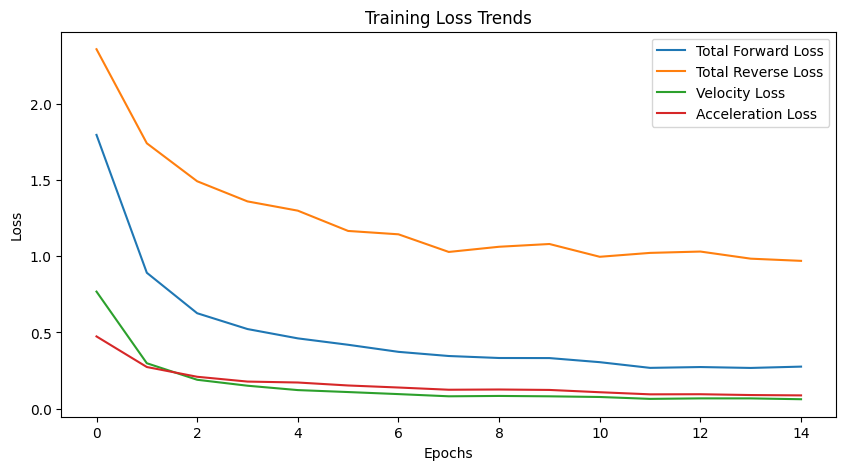

In [10]:
# Cell 8: Training Loop with Velocity and Acceleration Loss
loc_inn.train()
forward_loss = []
reverse_loss = []
z_loss_store = []
vel_loss_store = []
acc_loss_store = []

for epoch in range(num_epochs):
    for batch_idx, data_x in enumerate(data_loader):
        optimizer.zero_grad()
        with autocast(enabled=mix_precision):
            x_train = data_x[:, :num_link*3]
            y_gt = data_x[:, num_link*3:num_link*3+2]
            vel_gt = data_x[:, num_link*3+2:num_link*3+6]
            acc_gt = data_x[:, num_link*3+6:num_link*3+10]
            
            # Forward pass
            y_pred, para = loc_inn.forward(x_train)
            
            # Ensure y_pred has expected dimensions
            if y_pred.shape[1] < 12:
                raise RuntimeError(f"Unexpected y_pred shape: {y_pred.shape}")
            
            z_sample = torch.randn((x_train.shape[0], 2), dtype=torch.float32, device=device)
            
            # Compute loss components
            pos_loss = MSE_loss(y_pred[:, :2], y_gt)
            vel_loss = MSE_loss(y_pred[:, 2:6], vel_gt)
            acc_loss = MSE_loss(y_pred[:, 6:10], acc_gt)
            z_loss = MMD_matrix_multiscale(y_pred[:, 10:12], z_sample, mmd_forw_kernels, device)
            
            # Total forward loss
            tot_forward_loss = pos_loss + vel_loss + acc_loss + z_loss
        
        scaler.scale(tot_forward_loss).backward(retain_graph=True)
        
        with autocast(enabled=mix_precision):
            # Reverse pass
            y_rev = torch.cat((y_gt, vel_gt, acc_gt, y_pred[:, 10:12]), dim=1)

            if y_rev.shape[1] != x_train.shape[1]:
                raise RuntimeError(f"Dimension mismatch: y_rev {y_rev.shape}, expected {x_train.shape}")

            x_pred, _ = loc_inn.reverse(y_rev)
            
            loss_rev_origin_z = MMD_matrix_multiscale(x_pred, x_train, mmd_back_kernels, device)
            tot_backward_loss = MSE_loss(x_pred, x_train) + loss_rev_origin_z
        
        scaler.scale(tot_backward_loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
    
    # Store losses for visualization
    forward_loss.append(tot_forward_loss.item())
    reverse_loss.append(tot_backward_loss.item())
    z_loss_store.append(z_loss.item())
    vel_loss_store.append(vel_loss.item())
    acc_loss_store.append(acc_loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Pos Loss: {pos_loss.item()}, Vel Loss: {vel_loss.item()}, Acc Loss: {acc_loss.item()}, FLoss: {tot_forward_loss.item()}, RLoss: {tot_backward_loss.item()}, BLoss orig: {loss_rev_origin_z.item()}")

# Visualization
plt.figure(figsize=(10,5))
plt.plot(forward_loss, label='Total Forward Loss')
plt.plot(reverse_loss, label='Total Reverse Loss')
plt.plot(vel_loss_store, label='Velocity Loss')
plt.plot(acc_loss_store, label='Acceleration Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Trends')
plt.show()


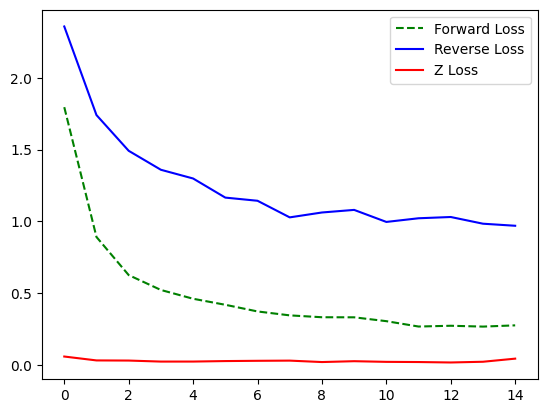

In [11]:
plt.figure()
plt.plot(forward_loss,'--g',label='Forward Loss')
plt.plot(reverse_loss,"-b",label="Reverse Loss")
plt.plot(z_loss_store,'-r',label="Z Loss")
plt.legend()
plt.show()

Saving the model parameters

In [12]:
torch.save(loc_inn.state_dict(), "INN_model.pth")

Testing

/tmp/ipykernel_16465/2869833260.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):


Target Position: [[-0.80901699  0.58778525]]
Number of Valid Configurations: 1


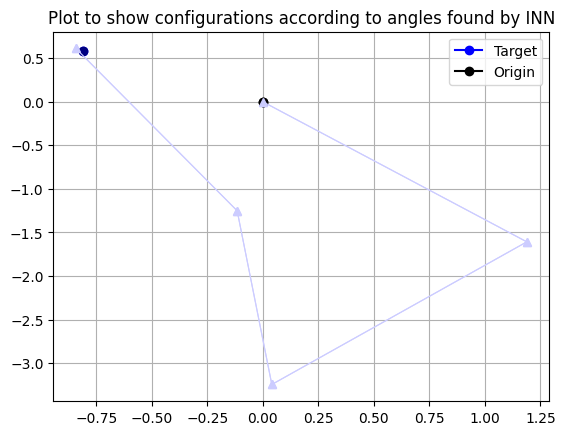

In [13]:
loc_inn.eval()
ran_int = 23567
angle_values = np.zeros((reps, num_link))  # num_link = 4

with torch.no_grad():
    with autocast(enabled=mix_precision):
        x_test = data_train[ran_int, :num_link * 3].unsqueeze(0).to(device)
        y_pred, param_model = loc_inn.forward(x_test)

        y_truth = data_train[ran_int, num_link * 3:num_link * 3 + 2].unsqueeze(0).to(device)
        inn_recon_loss = MSE_loss(y_pred[:, :2], y_truth)

        count = 0
        while count < reps:
            samples = torch.randn((y_pred.shape[0], num_link * 3 - 2), device=device)  # Adjusted sampling
            y_for_back = torch.cat((y_truth, samples), dim=1)  # Now shape = (1, num_link * 3)

            x_pred, back_params = loc_inn.reverse(y_for_back)
            angles = x_pred[:, :num_link].detach().cpu().numpy()
            angle_values[count, :] = angles
            count += 1

epsilon = 5e-2
p_x, p_y = np.zeros((5, reps)), np.zeros((5, reps))
flag = True
number_config = 0

plt.figure()
for i in range(reps):
    p_x[:, i], p_y[:, i] = posn(phi=angle_values[i, :])
    pose_found = np.array([[p_x[-1, i], p_y[-1, i]]])

    target_pose = data_ik[ran_int, num_link * 3:num_link * 3 + 2].reshape((1, 2))

    if np.linalg.norm(pose_found - target_pose) <= epsilon:
        if flag:
            plt.plot(target_pose[0, 0], target_pose[0, 1], 'b', marker='o', label="Target")
            plt.plot(0, 0, 'k', marker='o', label="Origin")
            plt.plot(p_x[:, i], p_y[:, i], marker='^', color=lighten_color("b", 0.2), lw=0.8)
            flag = False

        plt.plot(target_pose[0, 0], target_pose[0, 1], color=lighten_color("b", 1.5), lw=0.5, marker='o')
        plt.plot(0, 0, 'k', marker='o')
        plt.plot(p_x[:, i], p_y[:, i], marker='^', color=lighten_color("b", 0.2), lw=0.8)
        number_config += 1

print("Target Position:", target_pose)
print("Number of Valid Configurations:", number_config)

plt.legend()
plt.grid()
plt.title("Plot to show configurations according to angles found by INN")
plt.show()


In [14]:
# Cell 10: Trajectory Tracking - Initial Setup
loc_inn.eval()
angle_values = np.zeros((reps, num_link))

with torch.no_grad():
    with autocast(enabled=mix_precision):
        y_truth = torch.from_numpy(circle_points[0, :]).to(torch.float32).to(device).unsqueeze(0)

        count = 0
        while count < reps:
            # Generate enough random samples to match the expected shape
            samples = torch.randn((1, num_link * 3 - 2)).to(device)  # Adjusted sampling
            y_for_back = torch.cat((y_truth, samples), dim=1)  # Now shape = (1, num_link * 3)

            x_pred, back_params = loc_inn.reverse(y_for_back)
            angles = x_pred[:, :num_link].detach().cpu().numpy()
            angle_values[count, :] = angles[:]
            count += 1

# Find the initial angles that minimize the error distance
pred_end_eff = end_effector_posn(phi=angle_values[:, :])
error = circle_points[0, :] - pred_end_eff
error_dist = np.linalg.norm(error, axis=1)
chosen_ind = np.argmin(error_dist)
req_angles = angle_values[chosen_ind, :]

angle_val_rest = np.zeros((number_points - 1, reps, num_link))

for j in range(1, number_points):
    loc_inn.eval()
    with torch.no_grad():
        with autocast(enabled=mix_precision):
            y_truth = torch.from_numpy(circle_points[j, :]).to(torch.float32).to(device).unsqueeze(0)

            count = 0
            while count < reps:
                samples = torch.randn((1, num_link * 3 - 2)).to(device)  # Adjusted sampling
                y_for_back = torch.cat((y_truth, samples), dim=1)  # Now shape = (1, num_link * 3)

                x_pred, back_params = loc_inn.reverse(y_for_back)
                angles = x_pred[:, :num_link].detach().cpu().numpy().reshape((4,))
                angle_val_rest[j - 1, count, :] = angles[:]
                count += 1

final_movement = np.zeros((number_points, num_link))
final_movement[0, :] = req_angles
track = req_angles.reshape((1, num_link))


/tmp/ipykernel_16465/1765618583.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):
/tmp/ipykernel_16465/1765618583.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=mix_precision):


1)
[1. 0.] Actual
[0.98094629 0.06412617] Predicted

2)
[0.9781476  0.20791169] Actual
[8. 0.] Predicted

3)
[0.91354546 0.40673664] Actual
[0.90942534 0.43349276] Predicted

4)
[0.80901699 0.58778525] Actual
[0.81000281 0.56199794] Predicted

5)
[0.66913061 0.74314483] Actual
[0.68336409 0.70831763] Predicted

6)
[0.5       0.8660254] Actual
[8. 0.] Predicted

7)
[0.30901699 0.95105652] Actual
[0.34135402 0.9651313 ] Predicted

8)
[0.10452846 0.9945219 ] Actual
[0.07080182 0.96769238] Predicted

9)
[-0.10452846  0.9945219 ] Actual
[8. 0.] Predicted

10)
[-0.30901699  0.95105652] Actual
[-0.31182831  0.9659967 ] Predicted

11)
[-0.5        0.8660254] Actual
[-0.52779119  0.86149887] Predicted

12)
[-0.66913061  0.74314483] Actual
[-0.62565552  0.76675035] Predicted

13)
[-0.80901699  0.58778525] Actual
[-0.77846695  0.57231162] Predicted

14)
[-0.91354546  0.40673664] Actual
[-0.87525178  0.43651388] Predicted

15)
[-0.9781476   0.20791169] Actual
[-0.96440509  0.21451689] Predicted

1

/tmp/ipykernel_16465/4092226634.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  change_angles[ind] = np.linalg.norm(track - angle_val_rest[i, indi, :num_link], axis=1)


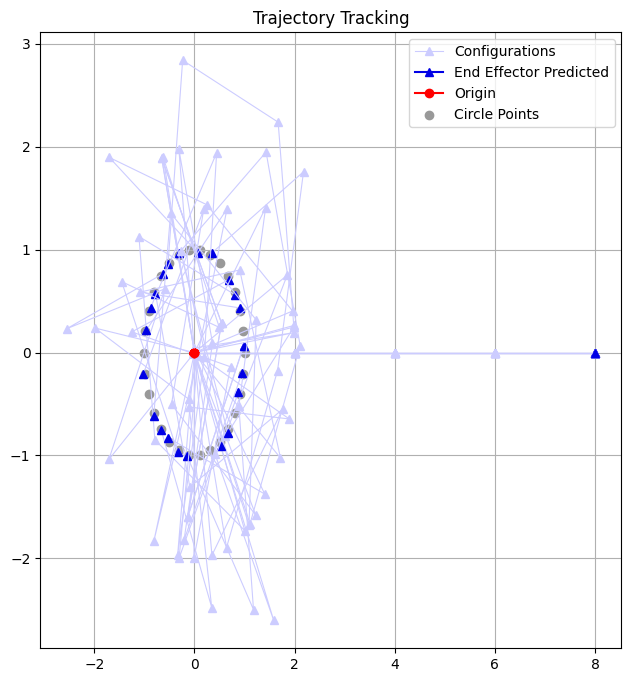

In [15]:
for i in range(number_points - 1):
    data_compare = circle_points[i, :].reshape((1, 2))
    pred_end_eff = end_effector_posn(phi=angle_val_rest[i, :, :])
    error = circle_points[i + 1, :] - pred_end_eff
    error_dist = np.linalg.norm(error, axis=1)

    indices = np.where(error_dist <= epsilon)[0]  # Ensure it's 1D

    if len(indices) == 0:  # Handle case where no valid indices are found
        print(f"Warning: No valid indices found at step {i}. Skipping this step.")
        continue

    change_angles = np.zeros(len(indices))

    for ind in range(len(indices)):
        indi = indices[ind]  # Extract index properly
        change_angles[ind] = np.linalg.norm(track - angle_val_rest[i, indi, :num_link], axis=1)

    chosen_ind = np.argmin(change_angles)
    req_ind = int(indices[chosen_ind])  # Extract index from indices array
    final_movement[i + 1, :] = angle_val_rest[i, req_ind, :num_link]
    track = angle_val_rest[i, req_ind, :num_link].reshape((1, num_link))

# Compute final positions
final_positions = np.zeros((number_points, num_link + 1, 2))
for i in range(final_movement.shape[0]):
    final_positions[i, :, :] = positions(phi=final_movement[i, :])  # Ensure correct function is used

# Print actual vs predicted positions
for j in range(circle_points.shape[0]):
    print(f"{j + 1})")
    print(circle_points[j, :], "Actual")
    print(final_positions[j, -1, :], "Predicted")
    print()

# Compute RMSE Loss
rmse_loss = np.sqrt(np.mean((final_positions[:, -1, :] - circle_points) ** 2))
print("RMSE Loss: ", rmse_loss)

# Plot trajectory tracking
plt.figure(figsize=(7.5, 8))
flag = True

for i in range(circle_points.shape[0]):
    px, py = positions(phi=final_movement[i, :])[:, 0], positions(phi=final_movement[i, :])[:, 1]  # Extract X, Y

    if flag:
        plt.plot(px, py, marker="^", color=lighten_color("b", 0.2), lw=0.8, label="Configurations")
        plt.plot(px[-1], py[-1], marker="^", color=lighten_color("b", 1.1), label="End Effector Predicted")
        plt.plot(0, 0, color="r", marker="o", label="Origin")
        flag = False
    plt.plot(px, py, marker="^", color=lighten_color("b", 0.2), lw=0.8)
    plt.plot(px[-1], py[-1], marker="^", color=lighten_color("b", 1.1))
    plt.plot(0, 0, color="r", marker="o")

plt.scatter(circle_points[:, 0], circle_points[:, 1], color=lighten_color("k", 0.4), label="Circle Points")
plt.grid()
plt.legend()
plt.title("Trajectory Tracking")
plt.show()


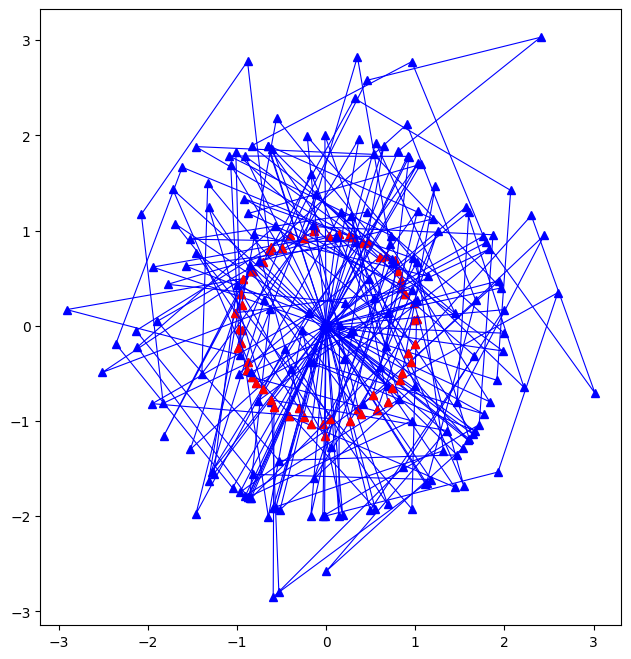

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Ensure circle_points has exactly 60 points
num_points = 60
num_link = 4

# Resize circle_points to 60 points
num_existing_points = circle_points.shape[0]
if num_existing_points < num_points:
    new_indices = np.linspace(0, num_existing_points - 1, num_points)
    interp_func_x = interp1d(np.arange(num_existing_points), circle_points[:, 0], kind='linear')
    interp_func_y = interp1d(np.arange(num_existing_points), circle_points[:, 1], kind='linear')
    circle_points = np.column_stack((interp_func_x(new_indices), interp_func_y(new_indices)))
elif num_existing_points > num_points:
    indices = np.linspace(0, num_existing_points - 1, num_points, dtype=int)
    circle_points = circle_points[indices]

angle_val_rest = np.zeros((num_points - 1, reps, num_link))

# Generate angle values using INN model
loc_inn.eval()
with torch.no_grad():
    for j in range(1, num_points):  # Now guaranteed to be in bounds
        y_truth = torch.tensor(circle_points[j, :], dtype=torch.float32, device=device).unsqueeze(0)
        count = 0
        while count < reps:
            samples = torch.randn((1, num_inputs - 2), device=device)  # Adjusted sampling
            y_for_back = torch.cat((y_truth, samples), dim=1)
            x_pred, _ = loc_inn.reverse(y_for_back)
            
            angles = x_pred[:, :num_link].detach().cpu().numpy().reshape((num_link,))
            angle_val_rest[j - 1, count, :] = angles
            count += 1

# Initialize final movement
final_movement = np.zeros((num_points, num_link))
final_movement[0, :] = req_angles

track = req_angles.reshape((1, num_link))

# Compute trajectory tracking movement
for i in range(num_points - 1):
    pred_end_eff = end_effector_posn(phi=angle_val_rest[i, :, :])
    error = circle_points[i + 1, :] - pred_end_eff
    error_dist = np.linalg.norm(error, axis=1)

    indices = np.where(error_dist <= epsilon)[0]  # Extract valid indices

    if len(indices) == 0:
        req_ind = np.argmin(error_dist)  # Fallback to best match
    else:
        change_angles = np.linalg.norm(track - angle_val_rest[i, indices, :], axis=1)
        req_ind = indices[np.argmin(change_angles)]

    final_movement[i + 1, :] = angle_val_rest[i, req_ind, :]
    track = final_movement[i + 1, :].reshape((1, num_link))

# Compute final positions
final_positions = np.zeros((num_points, num_link + 1, 2))
for i in range(num_points):
    final_positions[i, :, :] = positions(phi=final_movement[i, :])

# Plotting
plt.figure(figsize=(7.5, 8))
first_plot = True

for i in range(circle_points.shape[0]):
    joint_positions = positions(phi=final_movement[i, :])
    px, py = joint_positions[:, 0], joint_positions[:, 1]

    if first_plot:
        plt.plot(px, py, marker="^", color="b", lw=0.8, label="Configurations")
        plt.plot(px[-1], py[-1], marker="^", color="r", label="End Effector Predicted")
        plt.plot(0, 0, color="r", marker="o", label="Origin")
        first_plot = False
    else:
        plt.plot(px, py, marker="^", color="b", lw=0.8)
        plt.plot(px[-1], py[-1], marker="^", color="r")

plt.show()
